In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from datasets import load_dataset
import matplotlib.pyplot as plt
import flax.linen as nn
from jax.random import split, PRNGKey
from aevb import construct_aevb


def one_hot_encode(x, k):
    "Create a one-hot encoding of x of size k."
    return jnp.array(x[:, None] == jnp.arange(k), dtype=jnp.float32)


@jax.jit
def prepare_data(X):
    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    X = X / 255.0

    return X, num_examples


def data_stream(seed, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    rng = np.random.RandomState(seed)
    num_batches = int(jnp.ceil(data_size / batch_size))
    while True:
        perm = rng.permutation(data_size)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield data[batch_idx]


class MlpEncoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        return x


class MlpDecoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(784)(x)
        return x

    # -------------------------------- Data --------------------------------


mnist_data = load_dataset("mnist")
data_train, data_test = mnist_data["train"], mnist_data["test"]

X_train = np.stack([np.array(example["image"]) for example in data_train])
X_test = np.stack([np.array(example["image"]) for example in data_test])

X_train, N_train = prepare_data(X_train)
X_test, N_test = prepare_data(X_test)

key = PRNGKey(155)
n = N_train.item()
seed = 1
batch_size = 100
batches = data_stream(seed, X_train, batch_size, n)
encoder = MlpEncoder()
decoder = MlpDecoder()


class RecognitionModel(nn.Module):

    latent_dim: int
    encoder: nn.Module

    @nn.compact
    def __call__(self, x):

        x = self.encoder(x)
        # Project to mu, log variance
        z_mu = nn.Dense(features=self.latent_dim)(x)
        z_logvar = nn.Dense(features=self.latent_dim)(x)

        # Want to predict log variance so return sigma
        z_sigma = jnp.exp(z_logvar * 0.5)

        return z_mu, z_sigma


optimizer = optax.adam(1e-3)

aevb = construct_aevb(
    latent_dim=5,
    recognition_feature_extractor=encoder,
    generative_model=decoder,
    optimizer=optimizer,
    n_samples=1,
)

key = PRNGKey(122)
state = aevb.init(key, X_train.shape[-1])
#recognition_model = RecognitionModel(5, encoder)
#recognition_model.init(PRNGKey(123), jnp.ones(X_train.shape[-1]))


In [3]:
num_steps = 8000
eval_every = 100

keys = split(key, num_steps)
for i, rng_key in enumerate(keys):
    batch = next(batches)
    state, info = aevb.step(rng_key, state, batch)

    if i % eval_every == 0:
        print(f"Step {i} | loss: {info.loss} | nll: {info.nll} | kl: {info.kl}")



Step 0 | loss: 29699.021484375 | nll: 29693.83203125 | kl: 5.1902570724487305
Step 100 | loss: 5407.115234375 | nll: 4854.79296875 | kl: 552.3223876953125
Step 200 | loss: 4154.2392578125 | nll: 3519.23583984375 | kl: 635.00341796875
Step 300 | loss: 4031.719970703125 | nll: 3380.261474609375 | kl: 651.4585571289062
Step 400 | loss: 3794.66162109375 | nll: 3113.06494140625 | kl: 681.5966796875
Step 500 | loss: 3749.83642578125 | nll: 3054.19677734375 | kl: 695.6395874023438
Step 600 | loss: 3848.69384765625 | nll: 3197.39013671875 | kl: 651.3038330078125
Step 700 | loss: 3774.8515625 | nll: 3064.7001953125 | kl: 710.1514282226562
Step 800 | loss: 3540.6806640625 | nll: 2843.990966796875 | kl: 696.6897583007812
Step 900 | loss: 3576.17236328125 | nll: 2861.6796875 | kl: 714.4925537109375
Step 1000 | loss: 3499.448486328125 | nll: 2734.8203125 | kl: 764.628173828125
Step 1100 | loss: 3458.79443359375 | nll: 2780.12451171875 | kl: 678.6700439453125
Step 1200 | loss: 3565.9482421875 | nll:

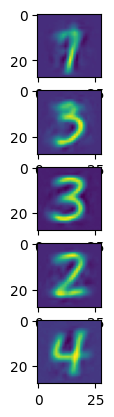

In [13]:
fig, axs = plt.subplots(5, 1)
key = PRNGKey(1233)
samples = aevb.sample_data(key, state.gen_params, 5)
for i, s in enumerate(samples):
    axs[i].imshow(s.reshape(28, 28))